In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import math
%matplotlib inline

In [2]:
run 'clean_data.py'

In [3]:
monthly_df = df[df['depth']<=20]

In [4]:
df = df.drop(df.columns[[1,2]], axis=1)

In [5]:
df.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
41,1984,80.7333,12.8533,37.0,-0.8118,347.7
42,1984,80.7333,12.8533,77.0,1.5336,315.0
43,1984,80.7333,12.8533,116.0,2.3164,317.6
44,1984,80.7333,12.8533,156.0,2.8303,314.1


In [6]:
surface = df[df['depth']<=20]

In [7]:
surface.head()

,year,latitude,longitude,depth,temperature,oxygen
39,1984,80.7333,12.8533,3.0,-0.8198,400.4
58,1984,80.9050,18.5883,5.0,2.3114,386.9
59,1984,80.9050,18.5883,18.0,1.2787,382.5
66,1984,81.0517,17.6683,6.0,1.7416,372.3
82,1984,81.1967,16.7933,4.0,-0.7188,398.3


# EDA

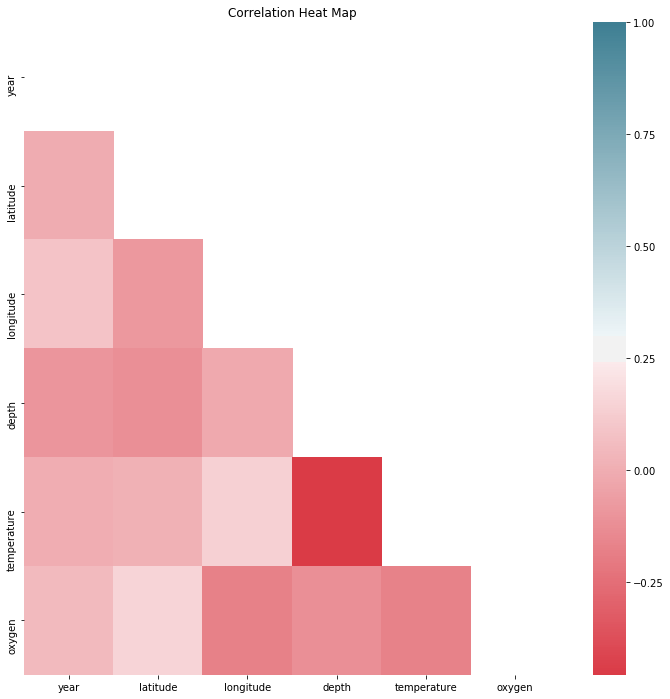

In [8]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Correlation Heat Map")

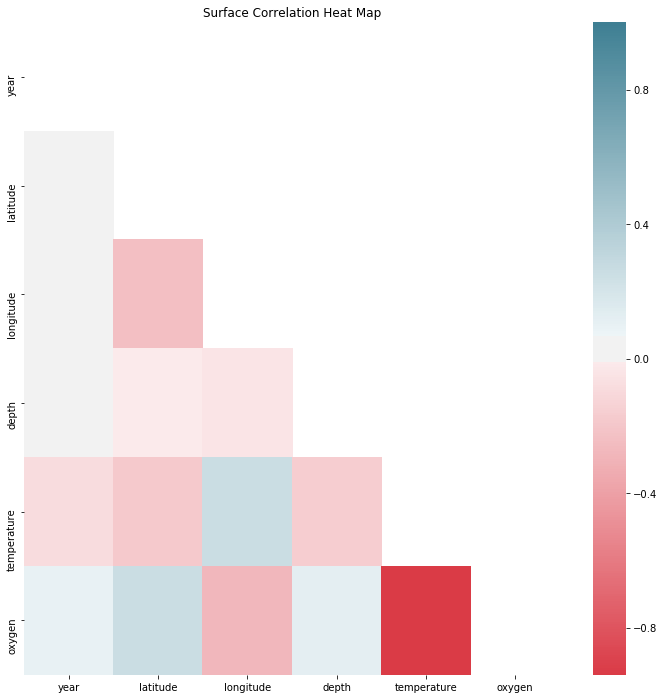

In [9]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(surface.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(surface.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

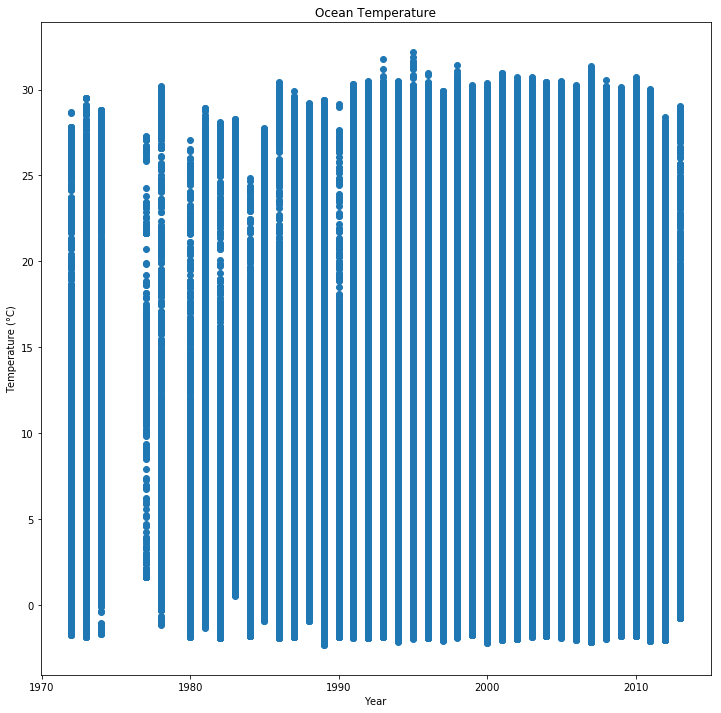

In [10]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Ocean Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(df['year'], df['temperature'])

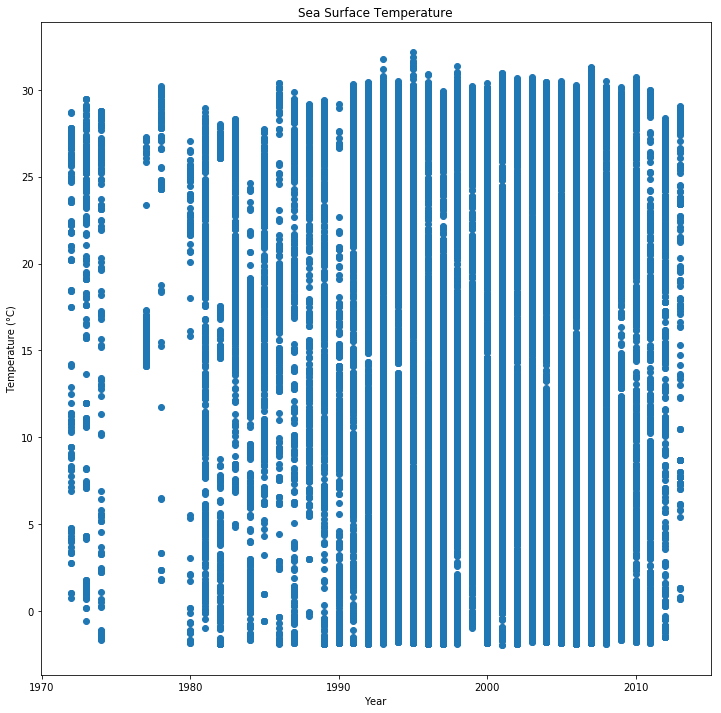

In [11]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.scatter(surface['year'], surface['temperature'])

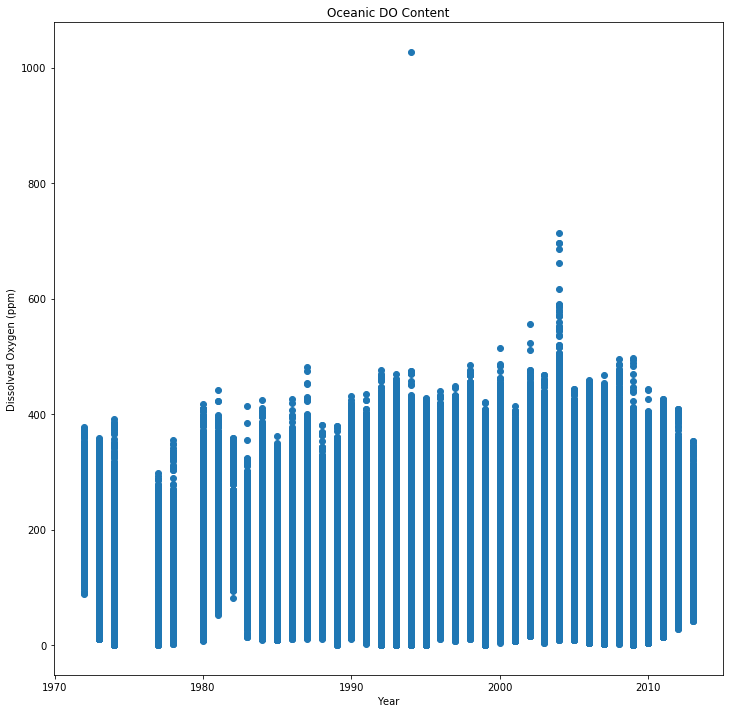

In [12]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Oceanic DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(df['year'], df['oxygen'])

### What is that outlier?

In [13]:
df[df['oxygen']>800]

,year,latitude,longitude,depth,temperature,oxygen
164928,1994,50.0058,-144.971,3345.0,1.5171,1026.9


### Let's keep it!

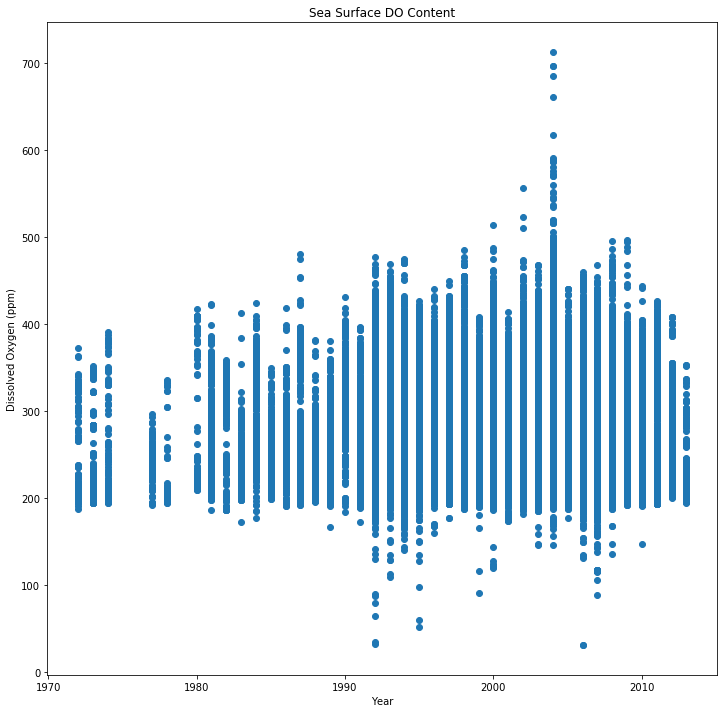

In [14]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_title('Sea Surface DO Content')
ax.set_xlabel('Year')
ax.set_ylabel('Dissolved Oxygen (ppm)')
ax.scatter(surface['year'], surface['oxygen'])

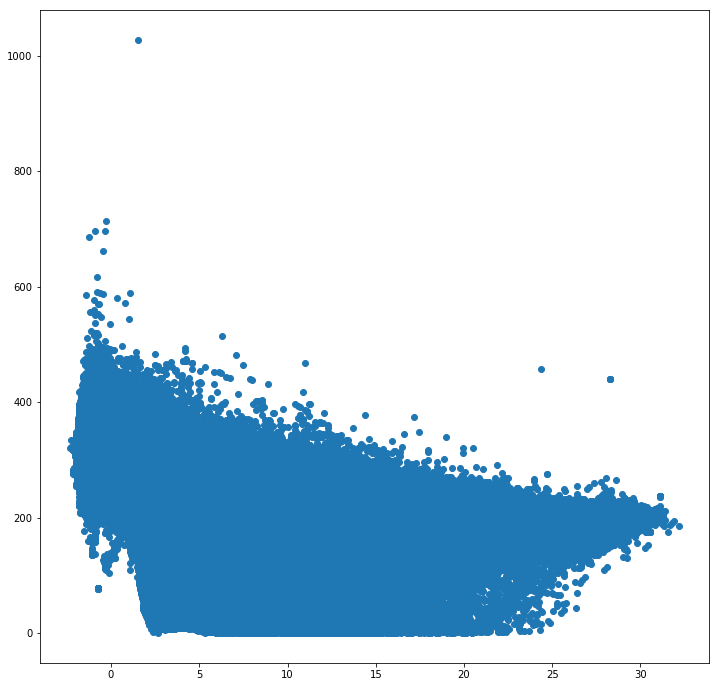

In [15]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)

ax.scatter(df['temperature'], df['oxygen'])

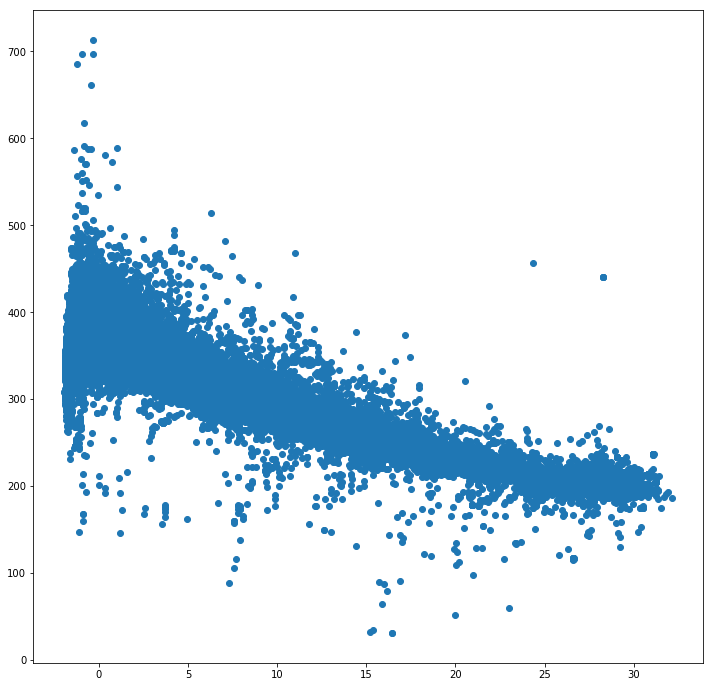

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(surface['temperature'], surface['oxygen'])

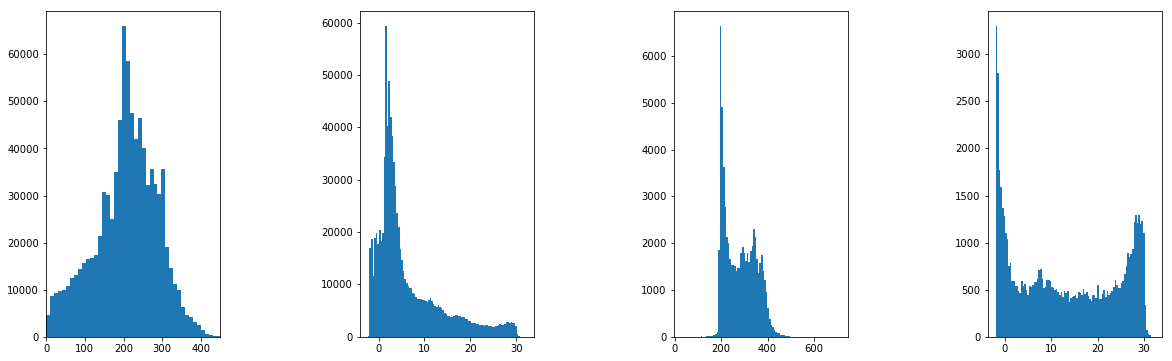

In [ ]:
fig = plt.figure(figsize=(20,6))
ax = fig.add_subplot(141)
ax.set_xlim(0, 450)
ax.hist(df['oxygen'], bins=100)

ax2 = fig.add_subplot(142)
ax2.hist(df['temperature'], bins=100)

ax3 = fig.add_subplot(143)
ax3.hist(surface['oxygen'], bins=100)

ax4 = fig.add_subplot(144)
ax4.hist(surface['temperature'], bins=100)
fig.subplots_adjust(wspace=0.8)

### Scatter Matrix

In [ ]:
_ = pd.plotting.scatter_matrix(df, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [ ]:
_ = pd.plotting.scatter_matrix(surface, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [8]:
surftemp = surface[['year','temperature']]

In [9]:
surftempbyyr = surftemp.groupby(['year'], as_index=False).mean()

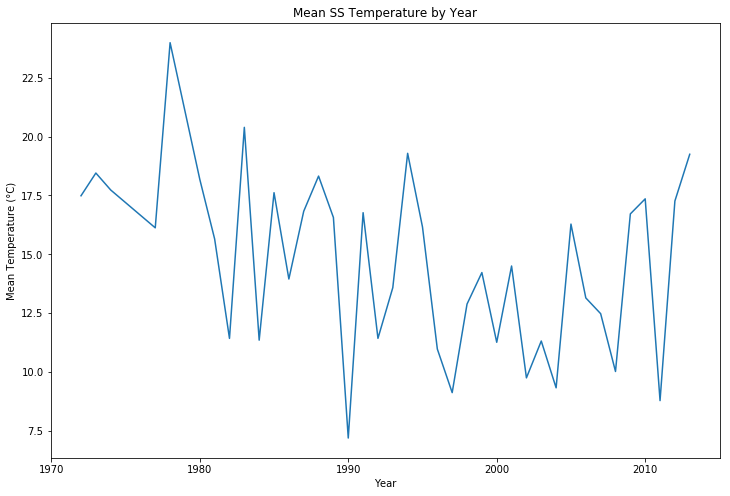

In [11]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Mean SS Temperature by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Temperature (°C)')
ax.plot(surftempbyyr['year'], surftempbyyr['temperature'])

## Exploring Summer

In [12]:
northern = monthly_df[monthly_df['latitude']>23.5]
southern = monthly_df[monthly_df['latitude']<-23.5]

In [13]:
northern_summer = northern.query('6 <= month <= 8')

In [14]:
southern_summer = southern[(southern['month']==12) | (southern['month']==1) | (southern['month']==2)]

In [15]:
summer = pd.concat([northern_summer, southern_summer])

In [16]:
summer_means = summer.groupby(['year'], as_index=False).mean()

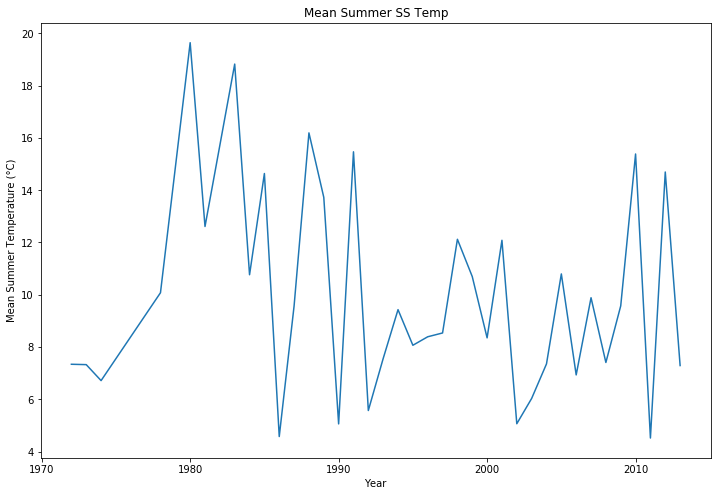

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Mean Summer SS Temp')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Summer Temperature (°C)')
ax.plot(summer_means['year'], summer_means['temperature'])

In [18]:
southern_winter = southern.query('6 <= month <= 8')

In [19]:
northern_winter = northern[(northern['month']==12) | (northern['month']==1) | (northern['month']==2)]

In [20]:
winter = pd.concat([northern_winter,southern_winter])

In [21]:
winter_means = winter.groupby(['year'], as_index=False).mean()

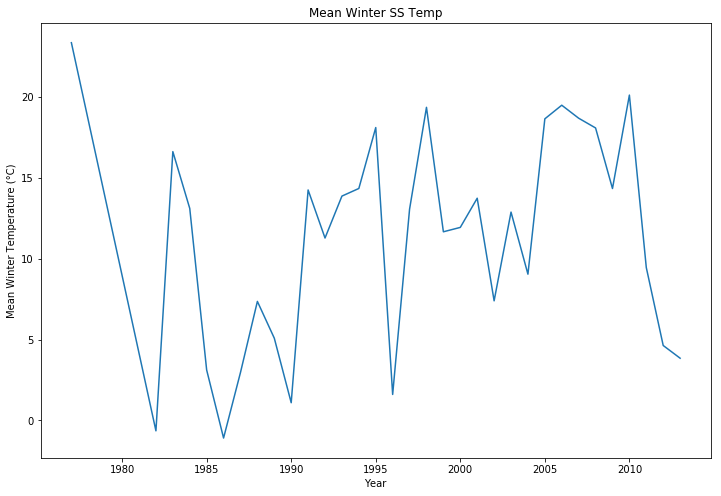

In [23]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Mean Winter SS Temp')
ax.set_xlabel('Year')
ax.set_ylabel('Mean Winter Temperature (°C)')
ax.plot(winter_means['year'], winter_means['temperature'])

### Welch's t-test: 1990s vs 2000s

In [24]:
winter_90s = winter.query('1990 <= year <= 1999')
winter_00s = winter.query('2000 <= year <= 2009')

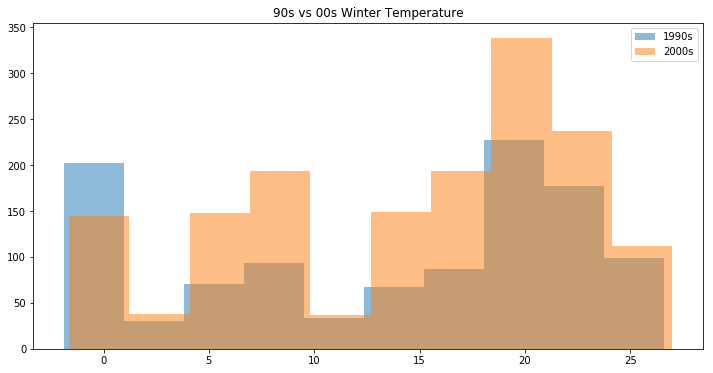

In [25]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(winter_90s['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(winter_00s['temperature'], alpha=0.5, label='2000s')
ax.legend()

In [26]:
stats.ttest_ind(winter_90s['temperature'],winter_00s['temperature'], equal_var=False)

Ttest_indResult(statistic=-3.47156741405691, pvalue=0.0005277833871404403)

In [27]:
summer_90s = summer.query('1990 <= year <= 1999')
summer_00s = summer.query('2000 <= year <= 2009')

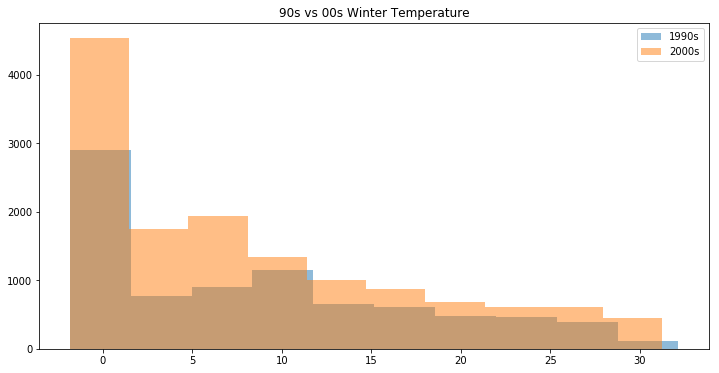

In [28]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.set_title('90s vs 00s Winter Temperature')
ax1 = ax.hist(summer_90s['temperature'], alpha=0.5, label='1990s')
ax2 = ax.hist(summer_00s['temperature'], alpha=0.5, label='2000s')
ax.legend()

In [29]:
stats.ttest_ind(summer_90s['temperature'],summer_00s['temperature'], equal_var=False)

Ttest_indResult(statistic=3.526090916159732, pvalue=0.0004228044642918308)

In [30]:
summer_90s['temperature'].mean()

8.621515504798028

In [31]:
summer_00s['temperature'].mean()

8.180991073446299

In [32]:
winter_90s['temperature'].mean()

13.30678130755063

In [33]:
winter_00s['temperature'].mean()

14.496017410433707

#### Temperature by decade is not normally distributed, but the t-test can still be valid with such large sample sizes. Below, we calculate p-values with the nonparametric Mann-Whitney U test.

In [34]:
stats.mannwhitneyu(winter_90s['temperature'],winter_00s['temperature'])

MannwhitneyuResult(statistic=812943.5, pvalue=0.004720990266716179)

In [35]:
stats.mannwhitneyu(summer_90s['temperature'],summer_00s['temperature'])

MannwhitneyuResult(statistic=56894925.5, pvalue=0.0015660627454797394)

## Predictive Modeling

In [38]:
df2 = pd.read_csv('data/master2.csv')

In [39]:
df2 = df2.drop(['ccl4','sf6', 'he', 'year', 'month', 'day'], axis=1)

In [45]:
df2 = df2[df2['temperature']!=-9999]
df2 = df2[df2['salinity']!=-9999]
df2 = df2[df2['oxygen']!=-9999]
df2 = df2[df2['nitrate']!=-9999]
df2 = df2[df2['nitrite']!=-9999]
df2 = df2[df2['phosphate']!=-9999]
df2 = df2[df2['phts25p0']!=-9999]
df2 = df2[df2['cfc11']!=-9999]
df2 = df2[df2['cfc12']!=-9999]
df2 = df2[df2['cfc113']!=-9999]
df2 = df2[df2['silicate']!=-9999]
df2.rename(columns={'talk': 'alkalinity'}, inplace=True)

In [46]:
df2.describe()

,latitude,longitude,depth,temperature,salinity,oxygen,nitrate,nitrite,silicate,phosphate,alkalinity,phts25p0,cfc11,cfc12,cfc113
count,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000,31547.000000
mean,8.253536,-26.571335,1283.271595,5.724036,34.716519,197.993750,23.680060,0.020162,54.294071,1.683078,2083.269796,7.674529,1.683111,0.900793,0.114578
std,45.223559,119.033673,1376.670063,6.866941,0.785496,82.745068,12.925481,0.062302,54.483097,0.903627,1733.892505,0.180098,1.821503,0.963196,0.168654
min,-75.750600,-179.829000,0.000000,-1.866600,12.939200,0.610000,-0.090000,-0.010000,-0.050000,-0.010000,-9999.000000,7.117830,-0.042000,-0.007000,-0.024000
25%,-29.152700,-133.337000,244.000000,1.493500,34.431600,149.765000,13.504200,0.000000,7.000000,0.960000,2293.300000,7.574800,0.086000,0.047000,0.003000
50%,24.007000,-65.990200,763.000000,3.135800,34.684200,200.600000,24.500000,0.000000,26.859400,1.720000,2323.700000,7.669800,1.053000,0.533000,0.035000
75%,35.704900,31.679000,1889.500000,7.303750,34.912900,261.200000,34.340000,0.010000,106.496000,2.420000,2366.500000,7.748695,2.557000,1.429000,0.148000
max,89.998300,179.985000,6368.000000,29.924000,37.520000,471.300000,45.430000,2.960000,229.856000,3.302700,2463.400000,8.364000,8.145000,4.342000,2.700000


Text(0.5,1,'Surface Correlation Heat Map')

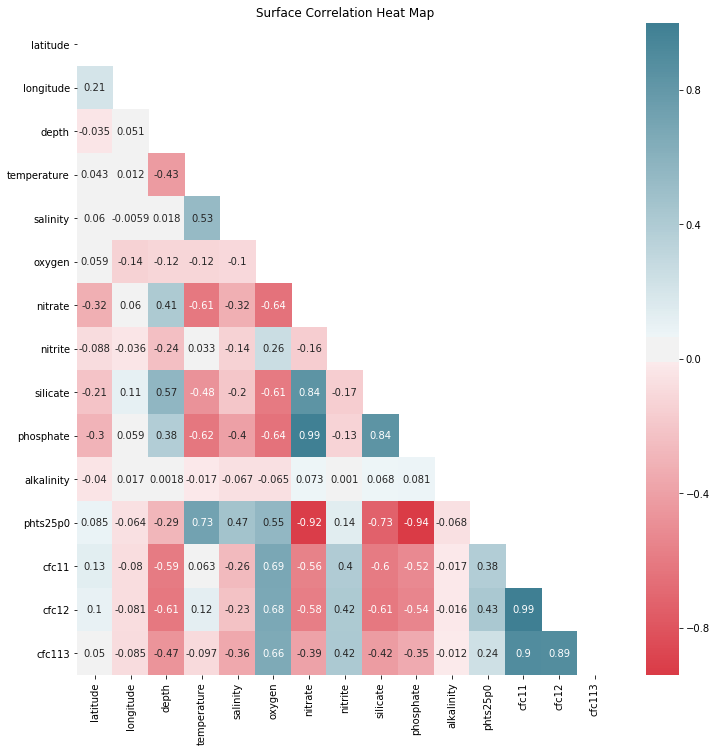

In [47]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df2.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df2.corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

In [50]:
columns = ['nitrate', 'nitrite', 'cfc113', 'latitude', 'alkalinity']

Text(0.5,1,'Surface Correlation Heat Map')

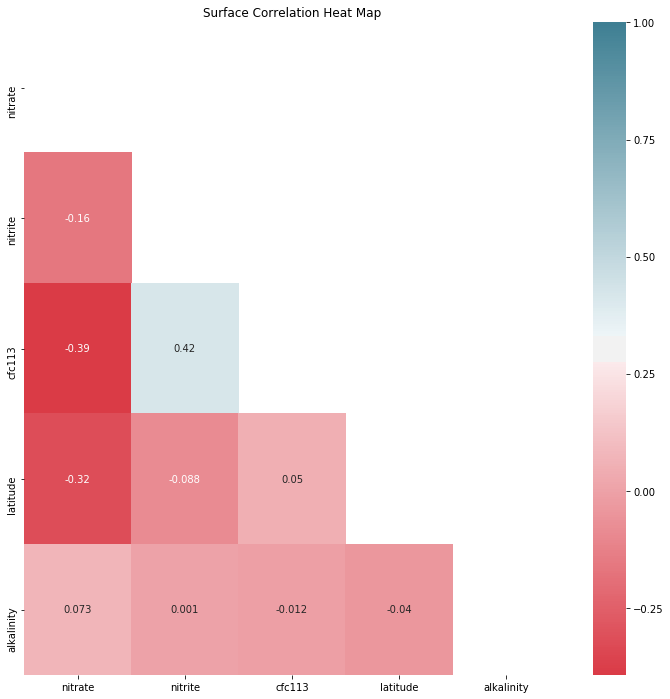

In [51]:
f, ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(df2[columns].corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(df2[columns].corr(), mask=mask, cmap=cmap, annot=True)
ax.set_title("Surface Correlation Heat Map")

In [74]:
df3 = df2['temperature']

In [75]:
df3 = df3.reindex()

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df3, df2['alkalinity'])

ValueError: Found input variables with inconsistent numbers of samples: [1, 31547]

In [68]:
linear = LinearRegression()
linear.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[4.4111 2.4356 1.844  ... 0.7843 5.358  4.9268].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [167]:
X_train.describe()

,nitrate,nitrite,cfc113,latitude
count,23660.000000,23660.000000,23660.000000,23660.000000
mean,23.681061,0.020253,0.114845,8.015175
std,12.906036,0.064412,0.169011,45.279242
min,-0.050000,-0.010000,-0.019000,-75.750600
25%,13.570000,0.000000,0.003000,-30.079100
50%,24.490000,0.000000,0.035000,23.731600
75%,34.330000,0.010000,0.148250,35.223700
max,45.430000,2.960000,2.700000,89.998300


RMSE: 4.615052373745166


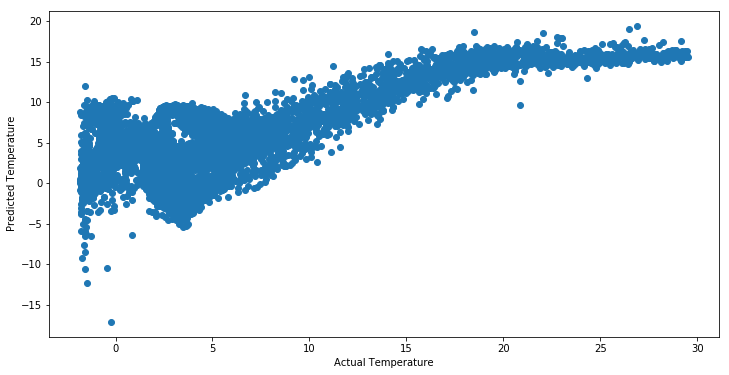

In [168]:
predicted_X_test = linear.predict(X_test)

print(f'RMSE: {math.sqrt(mean_squared_error(y_test, predicted_X_test))}')

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax.scatter(y_test, predicted_X_test)
ax.set_xlabel("Actual Temperature")
ax.set_ylabel("Predicted Temperature")